# Predicting Boston Housing Prices

## Using XGBoost in SageMaker (Deploy)

_Deep Learning Nanodegree Program | Deployment_

---

As an introduction to using SageMaker's Low Level Python API we will look at a relatively simple problem. Namely, we will use the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) to predict the median value of a home in the area of Boston Mass.

The documentation reference for the API used in this notebook is the [SageMaker Developer's Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/)

## General Outline

Typically, when using a notebook instance with SageMaker, you will proceed through the following steps. Of course, not every step will need to be done with each project. Also, there is quite a lot of room for variation in many of the steps, as you will see throughout these lessons.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

In this notebook we will be skipping step 5, testing the model. We will still test the model but we will do so by first deploying it and then sending the test data to the deployed model.

## Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [1]:
%matplotlib inline

import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In addition to the modules above, we need to import the various bits of SageMaker that we will be using. 

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [3]:
boston = load_boston()

## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 3: Uploading the training and validation files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the train and validation csv files which we will then upload to S3.

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [7]:
prefix = 'boston-xgboost-deploy-ll'
bucket = 'romeo-sandbox' # or session.default_bucket()


from sagemaker.s3 import S3Uploader

train_location = S3Uploader.upload(os.path.join(data_dir, 'train.csv'), f"s3://{bucket}/{prefix}", session = session)
val_location = S3Uploader.upload(os.path.join(data_dir, 'validation.csv'), f"s3://{bucket}/{prefix}", session = session)

print(train_location)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


s3://romeo-sandbox/boston-xgboost-deploy-ll/train.csv


## Step 4: Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [8]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# We now specify the parameters we wish to use for our training job
training_params = {}

training_params['Tags']=[
    {
            'Key': 'owner',
            'Value': 'email'
    },
]

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacst stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. You may wish to change these to see what effect
# there is on the resulting model.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


### Execute the training job

Now that we've built the dict containing the training job parameters, we can ask SageMaker to execute the job.

In [9]:
# First we need to choose a training job name. This is useful for if we want to recall information about our
# training job at a later date. Note that SageMaker requires a training job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

The training job has now been created by SageMaker and is currently running. Since we need the output of the training job, we may wish to wait until it has finished. We can do so by asking SageMaker to output the logs generated by the training job and continue doing so until the training job terminates.

In [10]:
session.logs_for_job(training_job_name, wait=True)

2020-06-07 19:31:32 Starting - Starting the training job...
2020-06-07 19:31:33 Starting - Launching requested ML instances......
2020-06-07 19:32:44 Starting - Preparing the instances for training......
2020-06-07 19:33:59 Downloading - Downloading input data
2020-06-07 19:33:59 Training - Downloading the training image...
2020-06-07 19:34:31 Uploading - Uploading generated training model
2020-06-07 19:34:31 Completed - Training job completed
Arguments: train
[2020-06-07:19:34:19:INFO] Running standalone xgboost training.
[2020-06-07:19:34:19:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8477.87mb
[2020-06-07:19:34:19:INFO] Determined delimiter of CSV input is ','
[19:34:19] S3DistributionType set as FullyReplicated
[19:34:19] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-07:19:34:19:INFO] Determined delimiter of CSV input is ','
[19:34:19] S3DistributionType set as Ful

### Build the model

Now that the training job has completed, we have some model artifacts which we can use to build a model. Note that here we mean SageMaker's definition of a model, which is a collection of information about a specific algorithm along with the artifacts which result from a training job.

In [11]:
# We begin by asking SageMaker to describe for us the results of the training job. The data structure
# returned contains a lot more information than we currently need, try checking it out yourself in
# more detail.
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [12]:
# Just like when we created a training job, the model name must be unique
model_name = training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Step 5: Test the trained model

We will be skipping this step for now. We will still test our trained model but we are going to do it by using the deployed model, rather than setting up a batch transform job.

## Step 6: Create and deploy the endpoint

Now that we have trained and constructed a model it is time to build the associated endpoint and deploy it. As in the earlier steps, we first need to construct the appropriate configuration.

In [13]:
# As before, we need to give our endpoint configuration a name which should be unique
endpoint_config_name = "boston-xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And then we ask SageMaker to construct the endpoint configuration
endpoint_config_info = session.sagemaker_client.create_endpoint_config(
                            Tags = [
                                {
                                    'Key': 'owner',
                                    'Value': 'email'
                                },
                            ],
                            EndpointConfigName = endpoint_config_name,
                            
                            # Different models / version of model
                            ProductionVariants = [{
                                "InstanceType": "ml.m4.xlarge",
                                "InitialVariantWeight": 1,
                                "InitialInstanceCount": 1,
                                "ModelName": model_name,
                                "VariantName": "AllTraffic"
                            }])

And now that the endpoint configuration has been created we can deploy the endpoint itself.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

In [14]:
# Again, we need a unique name for our endpoint
endpoint_name = "boston-xgboost-endpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And then we can deploy our endpoint
endpoint_info = session.sagemaker_client.create_endpoint(
                    EndpointName = endpoint_name,
                    EndpointConfigName = endpoint_config_name)

Just like when we created a training job, SageMaker is now requisitioning and launching our endpoint. Since we can't do much until the endpoint has been completely deployed we can wait for it to finish.

In [15]:
endpoint_dec = session.wait_for_endpoint(endpoint_name)

-------------!

## Step 7: Use the model

Now that our model is trained and deployed we can send test data to it and evaluate the results. Here, because our test data is so small, we can send it all using a single call to our endpoint. If our test dataset was larger we would need to split it up and send the data in chunks, making sure to accumulate the results.

In [16]:
# First we need to serialize the input data. In this case we want to send the test data as a csv and
# so we manually do this. Of course, there are many other ways to do this.
payload = [[str(entry) for entry in row] for row in X_test.values]
payload = '\n'.join([','.join(row) for row in payload])

In [17]:
# This time we use the sagemaker runtime client rather than the sagemaker client so that we can invoke
# the endpoint that we created.
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = endpoint_name,
                                                ContentType = 'text/csv',
                                                Body = payload)

# We need to make sure that we deserialize the result of our endpoint call.
result = response['Body'].read().decode("utf-8")
Y_pred = np.fromstring(result, sep=',')

To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

Text(0.5, 1.0, 'Median Price vs Predicted Price')

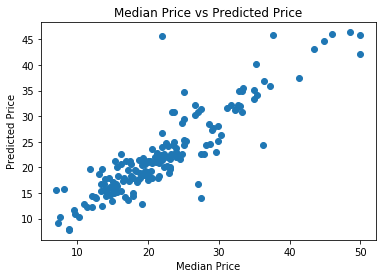

In [18]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Delete the endpoint

Since we are no longer using the deployed model we need to make sure to shut it down. Remember that you have to pay for the length of time that your endpoint is deployed so the longer it is left running, the more it costs.

In [ ]:
session.sagemaker_client.delete_endpoint(EndpointName = endpoint_name)

## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [20]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir